In [454]:
import itertools
import os
from os import path as pt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from hyperparameters import SIGCWGAN_CONFIGS
from lib import ALGOS
from lib.algos.base import BaseConfig
from lib.data import download_man_ahl_dataset, download_mit_ecg_dataset
from lib.data import get_data
from lib.plot import savefig, create_summary
from lib.utils import pickle_it
import Model_Evaluation


In [457]:
class Pipeline:
    def __init__(self, steps):
        """ Pre- and postprocessing pipeline. """
        self.steps = steps

    def transform(self, x, until=None):
        x = x.clone()
        for n, step in self.steps:
            if n == until:
                break
            x = step.transform(x)
        return x

    def inverse_transform(self, x, until=None):
        for n, step in self.steps[::-1]:
            if n == until:
                break
            x = step.inverse_transform(x)
        return x


class StandardScalerTS():
    """ Standard scales a given (indexed) input vector along the specified axis. """

    def __init__(self, axis=(1)):
        self.mean = None
        self.std = None
        self.axis = axis

    def transform(self, x):
        if self.mean is None:
            self.mean = torch.mean(x, dim=self.axis)
            self.std = torch.std(x, dim=self.axis)
        return (x - self.mean.to(x.device)) / self.std.to(x.device)

    def inverse_transform(self, x):
        return x * self.std.to(x.device) + self.mean.to(x.device)
    
    
    
def get_algo_config(dataset, data_params):
    """ Get the algorithms parameters. """
    key = dataset
    if dataset == 'VAR':
        key += str(data_params['dim'])
    elif dataset == 'STOCKS':
        key += '_' + '_'.join(data_params['assets'])
    return SIGCWGAN_CONFIGS[key]


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)


def get_algo(algo_id, base_config, dataset, data_params, x_real):
    if algo_id == 'SigCWGAN':
        algo_config = get_algo_config(dataset, data_params)
        algo = ALGOS[algo_id](x_real=x_real, config=algo_config, base_config=base_config)
    else:
        algo = ALGOS[algo_id](x_real=x_real, base_config=base_config)
    return algo

def get_dataset_configuration(dataset):
    if dataset == 'ECG':
        generator = [('id=100', dict(filenames=['100']))]
    elif dataset == 'STOCKS':
        generator = (('_'.join(asset), dict(assets=asset)) for asset in [('SPX',), ('SPX', 'DJI')])
    elif dataset == 'VAR':
        par1 = itertools.product([1], [(0.2, 0.8), (0.5, 0.8), (0.8, 0.8)])
        par2 = itertools.product([2], [(0.2, 0.8), (0.5, 0.8), (0.8, 0.8), (0.8, 0.2), (0.8, 0.5)])
        par3 = itertools.product([3], [(0.2, 0.8), (0.5, 0.8), (0.8, 0.8), (0.8, 0.2), (0.8, 0.5)])
        combinations = itertools.chain(par1, par2, par3)
        generator = (
            ('dim={}_phi={}_sigma={}'.format(dim, phi, sigma), dict(dim=dim, phi=phi, sigma=sigma))
            for dim, (phi, sigma) in combinations
        )
    elif dataset == 'ARCH':
        generator = (('lag={}'.format(lag), dict(lag=lag)) for lag in [3])
    elif dataset == 'SINE':
        generator = [('a', dict())]
    else:
        raise Exception('%s not a valid data type.' % dataset)
    return generator

def rolling_window(x, x_lag, add_batch_dim=True):
    if add_batch_dim:
        x = x[None, ...]
    return torch.cat([x[:, t:t + x_lag] for t in range(x.shape[1] - x_lag)], dim=0)



import argparse
parser = argparse.ArgumentParser()
# Meta parameters
parser.add_argument('-base_dir', default='./numerical_results', type=str)
parser.add_argument('-use_cuda', action='store_true')
parser.add_argument('-num_seeds', default=1, type=int)
parser.add_argument('-initial_seed', default=0, type=int)

parser.add_argument('-datasets', default=['STOCKS'], nargs="+")
parser.add_argument('-algos', default=['SigCWGAN'], nargs="+")
#parser.add_argument('-datasets', default=['ARCH', 'STOCKS', 'ECG', 'VAR', ], nargs="+")
#parser.add_argument('-algos', default=['SigCWGAN', 'GMMN', 'RCGAN', 'TimeGAN', 'RCWGAN', 'CWGAN',], nargs="+")

# Algo hyperparameters
parser.add_argument('-batch_size', default=200, type=int)
parser.add_argument('-p', default=3, type=int)
parser.add_argument('-q', default=3, type=int)
parser.add_argument('-hidden_dims', default=3 * (50,), type=tuple)
parser.add_argument('-total_steps', default=1000, type=int)
#args = parser.parse_args()
args = parser.parse_args(args=[])
args.use_cuda=True




print('Start of training. CUDA: %s' % args.use_cuda)
dataset=args.datasets[0]
algo_id=args.algos[0]
seed=0
base_config = BaseConfig(
                    device='cuda:0' if args.use_cuda else 'cpu',
                    seed=seed,
                    batch_size=args.batch_size,
                    hidden_dims=args.hidden_dims,
                    p=args.p,
                    q=args.q,
                    total_steps=args.total_steps,
                    mc_samples=1000,
                )
generator = get_dataset_configuration(dataset)




for spec, data_params in generator:
    print(spec, data_params)
spec, data_params='SPX' ,{'assets': ('SPX',)}
base_dir=args.base_dir
print('Executing: %s, %s, %s' % (algo_id, dataset, spec))
experiment_directory = pt.join(base_dir, dataset, spec, 'seed={}'.format(base_config.seed), algo_id)
set_seed(base_config.seed)

Start of training. CUDA: True
SPX {'assets': ('SPX',)}
SPX_DJI {'assets': ('SPX', 'DJI')}
Executing: SigCWGAN, STOCKS, SPX


In [458]:
from aiquantdb import QEData
qeds = QEData()
library = 'Tushare'
table = 'HS300IndexDailyPrices'
HS300=qeds.read(library=library, table=table, optional_col=None, optional_col_list=None, fields=None, start_date=None, end_date=None)


price = np.log(HS300[['close']].values)
rtn = (price[1:] - price[:-1]).reshape(1, -1, 1)
mu,std=np.mean(rtn),np.std(rtn)




#########
price_name=['open','high','low']
mu1,std1=[mu],[std]
data_raw=rtn
for name in price_name:
    price1 = np.log(HS300[[name]].values)
    rtn1 = (price1[1:] - price[:-1]).reshape(1, -1, 1)
    mu1.append(np.mean(rtn1))
    std1.append(np.std(rtn1))
    data_raw= np.concatenate([data_raw, rtn1], axis=-1)
############   



#vol = np.log(HS300[['vol']].values[-rtn.shape[1]:]).reshape(1, -1, 1)
#data_raw = np.concatenate([rtn, vol], axis=-1)
data_raw = torch.from_numpy(data_raw).float()
pipeline = Pipeline(steps=[('standard_scale', StandardScalerTS(axis=(0, 1)))])
data_preprocessed = pipeline.transform(data_raw)
assert data_preprocessed.shape[0] == 1
x_real = rolling_window(data_preprocessed[0], base_config.p + base_config.q)
print("data_preprocessed.shape:",data_preprocessed.shape)
print("x_real.shape:",x_real.shape)

[2021-11-12 02:30:03.040345] INFO: AiQuantDB: 读取操作：Tushare-HS300IndexDailyPrices


data_preprocessed.shape: torch.Size([1, 4066, 4])
x_real.shape: torch.Size([4060, 6, 4])


In [459]:
x_real=x_real.to(base_config.device)
x_real_train, x_real_test = train_test_split(x_real, train_size = 0.8)
algo = get_algo(algo_id, base_config, dataset, data_params, x_real_train)
algo.fit()

100%|███████████████████████████████████████| 1000/1000 [01:41<00:00,  9.87it/s]


In [460]:
algo.G

SimpleGenerator(
  (network): ResFNN(
    (network): Sequential(
      (0): ResidualBlock(
        (linear): Linear(in_features=16, out_features=50, bias=True)
        (activation): PReLU(num_parameters=1)
      )
      (1): ResidualBlock(
        (linear): Linear(in_features=50, out_features=50, bias=True)
        (activation): PReLU(num_parameters=1)
      )
      (2): ResidualBlock(
        (linear): Linear(in_features=50, out_features=50, bias=True)
        (activation): PReLU(num_parameters=1)
      )
      (3): Linear(in_features=50, out_features=4, bias=True)
    )
  )
)

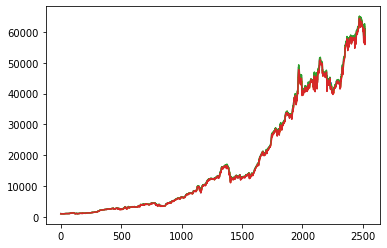

In [461]:
#画出某个生成样本的高开低收

init=np.array([HS300[['close']].values[0],HS300[['open']].values[0],HS300[['high']].values[0],HS300[['low']].values[0]]).reshape(-1)
with torch.no_grad():
    x_past = x_real_test[:, :base_config.p]
    x_p = x_past.clone().repeat(5, 1, 1)
    x_p = x_p[:1]
    x_fake_future = algo.G.sample(2520, x_p.to(base_config.device))
    
    #close
    log_return=x_fake_future[0,:,0].cpu().numpy()*std1[0]+mu1[0]
    price = np.exp(log_return)
    price0=(np.cumprod(price)*init[0]).reshape(-1,1)
    plt.plot(price0)
    price_all=price0
    
    for i in [1,2,3]:
        log_return=x_fake_future[0,:,i].cpu().numpy()*std1[i]+mu1[i]
        price = np.exp(log_return).reshape(-1,1)
        #price=np.cumprod(price)*init[i]
        price=price*np.vstack((init[0],price0[:-1]))
        plt.plot(price)
        price_all=np.hstack((price_all,price.reshape(-1,1)))
plt.show()

In [462]:
#判断涨跌停
for i in range(4):
    rate=(price_all[1:,i]-price_all[:-1,i])/price_all[:-1,i]
    print(sum(abs(rate)>0.1))

1
0
0
0


In [463]:
#k线图
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot

df = log_return
i = 500
j = 0
fig = go.Figure(data=go.Candlestick(
                    open=price_all[-100:,1],#df.iloc[1+j*featuresize,i:i+100],
                    high=price_all[-100:,2],#df.iloc[0+j*featuresize,i:i+100],
                    low=price_all[-100:,3],#df.iloc[2+j*featuresize,i:i+100],
                    close=price_all[-100:,0]))#df.iloc[3+j*featuresize,i:i+100]))
cs = fig.data[0]
#low=df.iloc[2, 0:100],
#open=df.iloc[1, 0:100],1

# Set line and fill colors
cs.increasing.fillcolor = '#FF4136'
cs.increasing.line.color = '#FF4136'
cs.decreasing.fillcolor = '#3D9970'
cs.decreasing.line.color = '#3D9970'
iplot(fig)

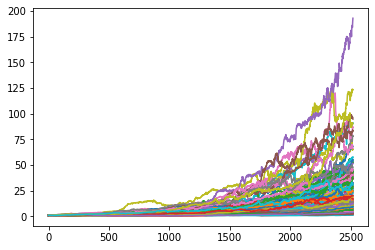

In [464]:
with torch.no_grad():
    x_past = x_real_test[:, :base_config.p]
    x_p = x_past.clone().repeat(5, 1, 1)
    x_p = x_p[:1]
    
    
    for i in range(100):
        x_fake_future = algo.G.sample(2520, x_p.to(base_config.device))
        
        log_return=x_fake_future[0,:,0].cpu().numpy()*std+mu
        if i==0:
            log_return_all=log_return.reshape(-1,1)
        else:
            log_return_all=np.hstack((log_return_all,log_return.reshape(-1,1)))
        price = np.exp(log_return)
        price=np.cumprod(price)
        plt.plot(price)
plt.show()

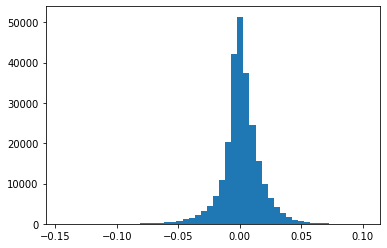

In [465]:
#生成样本分布
plt.hist(log_return_all.reshape(-1),bins=50)
plt.show()

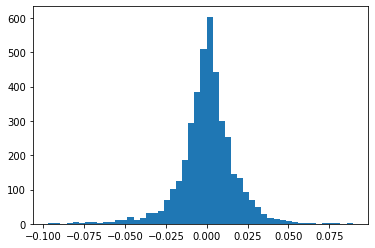

In [466]:
#真实样本分布
plt.hist(rtn.reshape(-1),bins=50)
plt.show()

(12,
 <AxesSubplot:title={'center':'gain_loss_asymmetry (True)'}, xlabel='lag K'>)

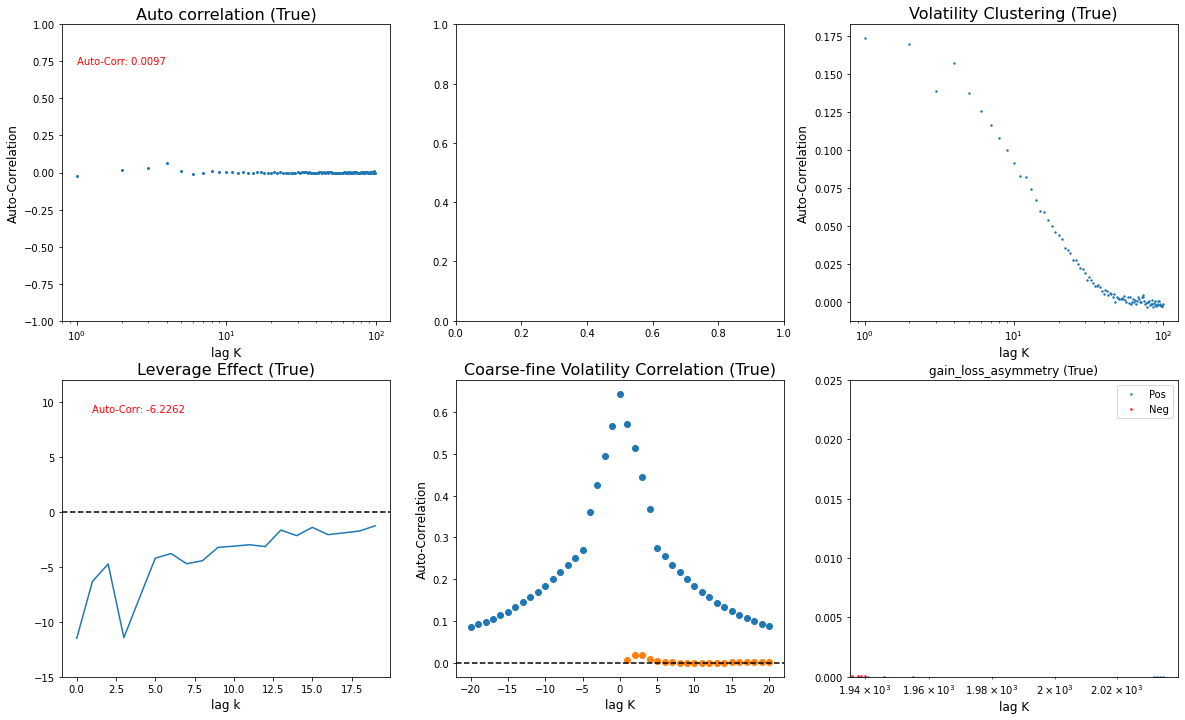

In [467]:
fig, axes = plt.subplots(2,3, figsize = (20, 12))

me = Model_Evaluation.Model_Evaluation(pd.DataFrame(log_return_all))
auto_cor=me.auto_correlation_avg( maxLags=100, title="Auto correlation (True)", plot = True, ax = axes[0,0])

me.vol_cluster_test_avg(title="Volatility Clustering (True)", plot = True, ax = axes[0, 2])

me.leverage_effect_testing_avg(maxLag=20, plot = True, title="Leverage Effect (True)", ax = axes[1,0])

me.coarse_fine_vol_corr_test_avg(lags=20, title="Coarse-fine Volatility Correlation (True)", plot = True, ax = axes[1, 1])

me.gain_loss_asymmetry(title = "gain_loss_asymmetry (True)", plot = True, ax = axes[1,2])

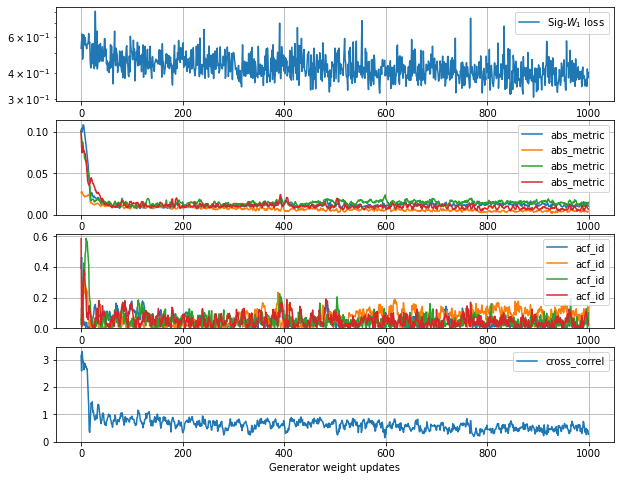

In [468]:
algo.plot_losses()